<a href="https://colab.research.google.com/github/dibyanshu-8/Micrscope-slide-analysis--OpenCV/blob/main/Microscope_slide_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Microscope Slide Analysis Tool

In [22]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
print("libraries imported successfully")

libraries imported successfully


In [23]:
def download_sample_image():
  print('downloading sample image...')
  # Use a sample image URL that provides a standard image format
  image_url='https://histologyguide.com/imgs/EM-398c-pyramidal-neuron.jpg'
  try:
    response = requests.get(image_url)
    #raising an exception for bad status codes
    response.raise_for_status()
    img=Image.open(BytesIO(response.content))
    #convert PIL image to opencv format(BGR)
    img_cv=cv2.cvtColor(np.array(img),cv2.COLOR_RGB2BGR)
    print('sample image downloaded & converted to opencv format')
    return img_cv
  except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
    return None

In [24]:
def display_images(images,titles):
  plt.figure(figsize=(15,5))
  for i,(image,title) in enumerate(zip(images,titles)):
    plt.subplot(1,len(images),i+1)
    #convert BGR(opencv default) to RGB for correct display in matplotlib
    if len(image.shape)==3:
      plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    else:
      plt.imshow(image,cmap='gray') #grayscale image

    plt.title(title)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [25]:
#cell count & core analysis
def analyze_cell_count(image):
  #perform the main cell counting logic using opencv
  print("starting cell count analysis")
  if image is None:
    print('cannot perform analysis as input image is missing')
    return

  #convert the image to grayscale
  gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  print("image converted to grayscale")

  #apply a binary threshold to create a black & white image
  _,threshold_image=cv2.threshold(gray_image,200,255,cv2.THRESH_BINARY_INV)
  print('binary threshold applied to isolate cells')

  #finding contours(outlines) of the white objects/cells in the thresholded image
  contours,_=cv2.findContours(threshold_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  print('initial contours found')

  #filter contours to remove small noise & count only cell like objects
  min_area=20 #this is the minimum pixel area to be considered as cell
  cell_contours=[c for c in contours if cv2.contourArea(c)>min_area]
  print(f'Filtered contours & {len(cell_contours)} cells detected')

  #draw the detected contours on the original image for visualization
  output_image=image.copy()
  #draw in bright green
  cv2.drawContours(output_image,cell_contours,-1,(0,255,0),2)
  print('contours drawn on the original image')

  #display the processing stages
  display_images([image,gray_image,threshold_image,output_image],
                 ['original image','grayscale image','threshold',f'cells detected ({len(cell_contours)})']
                 )

  return len(cell_contours)



In [26]:
#focus quality analysis by calculating the variance of the laplacian
def analyze_focus_quality(image):
  print('starting focus quality analysis')
  if image is None:
    print('cannot perform analysis as input image is missing')
    return

  #convert to grayscale as focus is independent of color
  gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  #compute the laplacian of the grayscale image & then the variance
  laplacian_var=cv2.Laplacian(gray,cv2.CV_64F).var()
  #define a heuristic threshold.we can adjust this value
  focus_threshold=500.0
  status='In focus' if laplacian_var > focus_threshold else 'Blurry'

  print(f'laplacian variance(focus score):{laplacian_var:.2f}')
  print(f'image quality status:{status}')

  return laplacian_var,status



downloading sample image...
sample image downloaded & converted to opencv format
starting cell count analysis
image converted to grayscale
binary threshold applied to isolate cells
initial contours found
Filtered contours & 5 cells detected
contours drawn on the original image


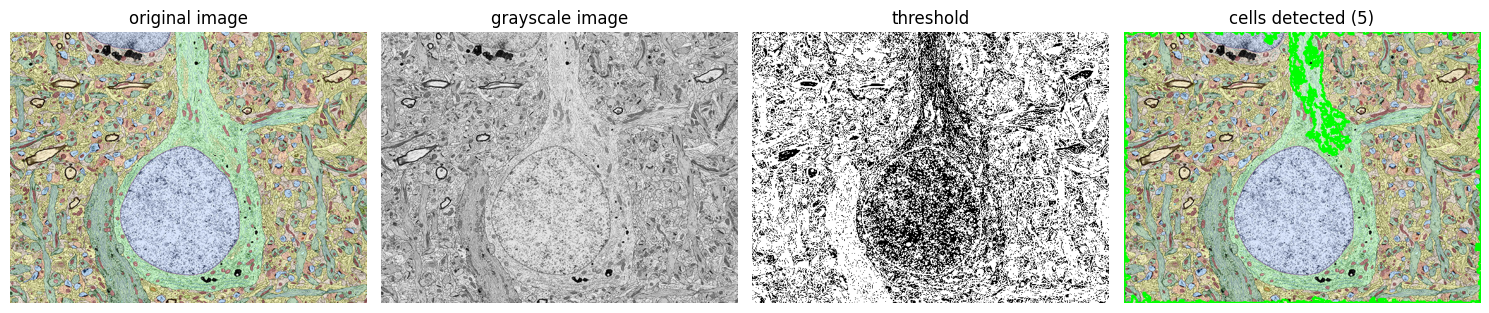

starting focus quality analysis
laplacian variance(focus score):10377.47
image quality status:In focus


In [27]:
#execution part
if __name__=='__main__':
  #loading the sample image
  sample_image=download_sample_image()
  if sample_image is not None:
    analyze_cell_count(sample_image)
    analyze_focus_quality(sample_image)